In [1]:
import tensorflow as tf
import numpy as np
import deepxde as dde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Set the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi,dtype=DTYPE)

def fun_u_0(x):
    return tf.sin( pi * x)

def fun_p_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def fun_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def f(x,t):
    return tf.constant(np.pi,dtype='float32')*(tf.exp(-2*t)*tf.sin(np.pi*x)*tf.cos(np.pi*x)) -  tf.constant(2,dtype='float32')*x

def residual(u,u_t,u_x,u_xx,p_x, l1, x,t):
    
    f_val = f(x,t)
    f_u = u_t + u*u_x- l1*u_xx + p_x - f_val

    return f_u

class PhysicsInformedNN:
    def __init__(self, lb, ub, layers, u0, x0, X):

        self.lambda1 = 1/tf.constant(np.power(np.pi,2),dtype='float32')
        self.lb = lb
        self.ub = ub
                
        self.layers = layers

        self.u0 = u0
        self.X0 = x0

        self.X = X

        self.model = self.initialize_NN(layers)

    def initialize_NN(self,layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(layers[0]))
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x-self.lb)/(self.ub-self.lb)-1.0)
        model.add(scaling_layer)
        num_layers = len(layers)
        for i in range(1,num_layers-2):
            model.add(tf.keras.layers.Dense(layers[i],
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(layers[-1]))

        return model
    

    def loss(self, X, X0, u0):
        
        u_p_pred = self.model(X0)
        u_pred = u_p_pred[:,0:1]

        loss = tf.reduce_mean(tf.square(u0-u_pred))

        r1 = self.get_residual(X)

        phi_ru = tf.reduce_mean(tf.square(r1))

        loss += phi_ru

        return loss
    
    def get_residual(self,X):
        with tf.GradientTape(persistent=True) as tape:
            x = X[:,0:1]
            t = X[:,1:2]

            tape.watch(x)
            tape.watch(t)

            u_p = self.model(tf.stack([x[:,0],t[:,0]], axis=1))

            u = u_p[:,0:1]
            p = u_p[:,1:2] 


            u_t = tape.gradient(u,t)
            u_x = tape.gradient(u,x)
            u_xx = tape.gradient(u_x,x)

            p_x = tape.gradient(p,x)

        del tape
        
        l1 = self.lambda1
        f_u = residual(u,u_t,u_x,u_xx,p_x,l1, x, t)

        return f_u
    
    def loss_gradient(self,X,X0,u0, v0):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss(self, X, X0, u0, v0)
            g = tape.gradient(loss, self.model.trainable_variables)

        del tape
        return loss, g

    
    
    def train(self):
        def time_step():
            loss = self.loss(self.X, self.X0, self.u0)
            return loss
        variables = self.model.trainable_variables
        cor=50
        tol=1.0  * np.finfo(float).eps
        iter=50000
        fun=50000
        ls=50
        dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
        dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    # def optimization_step(self, cor=50, tol=1.0  * np.finfo(float).eps,  iter=50000, fun=50000, ls=50):
    #     def time_step():
    #         loss = self.loss(self.X, self.X0, self.u0)
    #         return loss
    #     variables = self.model.trainable_variables
    #     dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
    #     dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    #     return loss


In [3]:
import scipy

In [4]:
layers = [2, 10, 10, 10, 10, 10, 10, 2]
layerp = [2, 10, 10, 10, 10, 10, 1]
layeru = [2, 20, 20, 20, 20, 20, 1]

N_0 = 100
N_b = 200
N_r = 10000

tmin = 0.
tmax = 2.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([xmin, tmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, tmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[1]
x_0 = tf.random.uniform((N_0,1), lb[0], ub[0], dtype=DTYPE)
X_0 = tf.concat([x_0 , t_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b = lb[1] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, t_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)
p_b = fun_p_b(t_b, x_b)
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
X_r = tf.concat([ x_r,t_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b],0)
u_data = tf.concat([u_0, u_b],0)


In [5]:
model = PhysicsInformedNN(xmin, xmax, layers, u_data, X_data, X_r)

In [6]:
def time_step():
        loss = model.loss(model.X, model.X0, model.u0)
        return loss

In [7]:
variables = model.model.trainable_variables

In [8]:
cor=50
tol=1.0  * np.finfo(float).eps
iter=50000
fun=50000
ls=50

In [9]:
dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)

In [10]:
dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=True>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=2896>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=8107>, position=<tf.Tensor: shape=(382,), dtype=float32, numpy=
array([-4.18007284e-01,  2.73306668e-01, -4.14893925e-02,  2.50840425e-01,
        5.32406628e-01,  5.18448830e-01,  1.84677422e-01, -7.57536888e-01,
       -3.99607539e-01,  7.02443719e-01,  2.42834538e-01, -9.86802936e-01,
       -4.32400495e-01,  2.14409716e-02,  4.79443260e-02, -6.04534805e-01,
        2.88942218e-01,  4.78249379e-02, -9.42874607e-03, -4.86033373e-02,
        1.49347365e-01, -1.23351574e+00, -6.34443998e-01, -2.67038077e-01,
        1.36128783e-01, -7.50103593e-01,  3.77687246e-01,  4.38853443e-01,
        4.17637914e-01,  8.26220810e-01,  6.64184168e-02,  3.06024775e-02,
        6.49153516e-02,  4.73418176e-01,  7.05672562e-01,  1.62290528e-0

In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [6]:
import matplotlib.animation as animation

In [14]:
tiempo = []
sol1 = []
sol2 = []

x1 = np.arange(xmin,xmax,0.01)
xn = tf.convert_to_tensor(np.transpose([np.ravel(x1)]))

for i in np.arange(tmin,tmax,0.01):
    t = np.ones(x1.shape)*i
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
    X = tf.concat([xn,tn],1)
    z = model.model(X)
    z = z.numpy()
    z = z.reshape(x1.shape)
    z2 = np.sin(np.pi*x1)*np.exp(-t)

    tiempo.append(t)
    sol1.append(z)
    sol2.append(z2)



In [7]:
x = np.arange(xmin,xmax,0.01)
t = np.arange(tmin,tmax,0.01)
x,t = np.meshgrid(x,t)

xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]), dtype=DTYPE)
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]), dtype=DTYPE)
X = tf.concat([xn,tn],1)

In [16]:
modelo = tf.saved_model.load("PINN_1D_Export7")

In [27]:
modelou = tf.saved_model.load("PINN_1D_u_Export_best")
modelop = tf.saved_model.load("PINN_1D_p_Export_best")

In [17]:
z = modelo.serve(X)

In [18]:
u = z[:,0:1]
p = z[:,1:2]

u = u.numpy()
u = u.reshape(x.shape)


p = p.numpy()
p = p.reshape(x.shape)

In [30]:
p_ = modelop.serve(X)
p_ = p_.numpy()
p_ = p_.reshape(x.shape)

In [31]:
u_ = modelou.serve(X)
u_ = u_.numpy()
u_ = u_.reshape(x.shape)

In [19]:
u2 = np.sin(np.pi*x)*np.exp(-t)
p2 = - np.sin(np.pi*x)

In [20]:
np.sqrt(np.sum(np.power(u2-u,2)))

13.316041199591924

In [21]:
np.sqrt(np.sum(np.power(p2-p,2)))

13.785243614179102

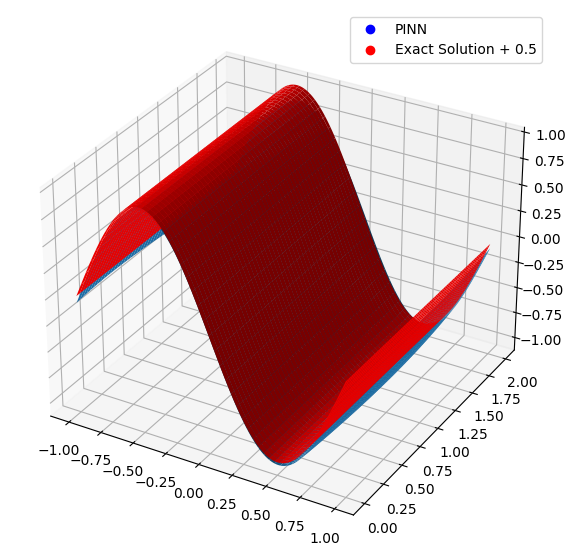

In [22]:
import matplotlib as mpl

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, p)
ax.plot_surface(x, t, p2, color='r')



fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)



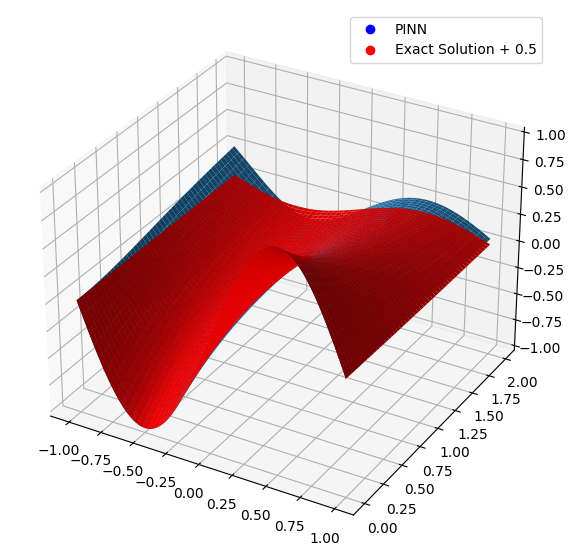

In [23]:
import matplotlib as mpl

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, u)
ax.plot_surface(x, t, u2, color='r')



fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)
